# AGNerds Project

#### PRIMER is a project with the James Webb Space Telescope that is observing two different fields (UDS and COSMOS) that were also observed with the Hubble Space Telescope.

#### Hubble observed these fields as part of the CANDELS program. Extensive work was done by the team over the course of a decade to measure the redshift (or distance from us) and mass of each galaxy. The CANDELS catalogs are saved as the “uds…fits” and “cosmos…fits” files. Download TOPCat (https://www.star.bris.ac.uk/~mbt/topcat/#intro) to easily view fits files. Now, the PRIMER team has also measured these quantities using JWST data.

#### It is imperative that we determine how good the new measurements are. The PRIMER data is going to be used by several group members, and we must decide which redshifts to use.

#### Christian will match the PRIMER photometric catalogs with the original HST photometric catalogs using RA and Dec. He will determine whether matches are correct by looking at the photometric fluxes in each catalog. He will then plot the redshifts from each catalog and the stellar masses to determine how well they agree.


# First, lets open up the files

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import astropy as ast
from astropy import units as u
from astropy.io import fits
import astropy.table
from astropy.table import QTable

In [67]:
PrimerCosmos = fits.open('PRIMER-COSMOS_v2.0.0_LW_Kf444w_SUPER_CATALOG.fits')
PrimerUDSSuper = fits.open('PRIMER-UDS_v2.0.0_LW_Kf444w_SUPER_CATALOG.fits')
PrimerUDS = fits.open('PRIMER-UDS_v2.0.0_catalog (1).fits')
HSTCosmos = fits.open('cos_merged_v1.1.fits')
HSTUDS = fits.open('uds_merged_v1.1.fits')

# First lets grab the RA and DEC values from the cataloges. You can do this by looking at the headers.

In [80]:
PrimerCosmosID = PrimerCosmos[1].data['id']
PrimerUDSSuperID = PrimerUDSSuper[1].data['id']
PrimerUDSID = PrimerUDS[1].data['ID']
HSTCosmosID = HSTCosmos[1].data['ID']
HSTUDSID = HSTUDS[1].data['ID']

PrimerCosmosRA = PrimerCosmos[1].data['ra']
PrimerCosmosDEC = PrimerCosmos[1].data['dec']

PrimerUDSSuperRA = PrimerUDSSuper[1].data['ra']
PrimerUDSSuperDEC = PrimerUDSSuper[1].data['dec']

PrimerUDSRA = PrimerUDS[1].data['ra']
PrimerUDSDEC = PrimerUDS[1].data['dec']

HSTCosmosRA = HSTCosmos[1].data['RA']
HSTCosmosDEC = HSTCosmos[1].data['DEC']

HSTUDSRA = HSTUDS[1].data['RA']
HSTUDSDEC = HSTUDS[1].data['DEC']

PrimerUDSZphote = PrimerUDS[1].data['z_phot']
CosmosZPhote= HSTCosmos[1].data['zphot']
UDSZPhote = HSTUDS[1].data['zphot']

In [82]:
#Using QTable to create a table with the ID, RA, DEC, and ZPHOTE
PrimerCosmosTable = QTable([PrimerCosmosID, PrimerCosmosRA, PrimerCosmosDEC], names=('ID', 'RA', 'DEC'), dtype=(int, float, float))
PrimerUDSSuperTable = QTable([PrimerUDSSuperID, PrimerUDSSuperRA, PrimerUDSSuperDEC, PrimerUDSZphote], names=('ID', 'RA', 'DEC', 'z_phot'), dtype=(int, float, float, float))
PrimerUDSTable = QTable([PrimerUDSID, PrimerUDSRA, PrimerUDSDEC, PrimerUDSZphote], names=('ID', 'RA', 'DEC', 'z_phot'), dtype=(int, float, float, float))
HSTCosmosTable = QTable([HSTCosmosID, HSTCosmosRA, HSTCosmosDEC, CosmosZPhote], names=('ID', 'RA', 'DEC', 'z_phot'), dtype=(int, float, float, float))
HSTUDSTable = QTable([HSTUDSID, HSTUDSRA, HSTUDSDEC, UDSZPhote], names=('ID','RA', 'DEC', 'z_phot'), dtype=(int, float, float, float))


#Print out the tables
#PrimerCosmosTable
#PrimerUDSSuperTable
#PrimerUDSTable
#HSTCosmosTable

In [70]:
#Print out the length of the tables
print(len(PrimerCosmosTable))
print(len(PrimerUDSSuperTable))
print(len(PrimerUDSTable))
print(len(HSTCosmosTable))

116247
78275
78275
38671


# To compare the RA and Dec, I want to first create a boundary which is the Point Spread Function. The PSF is the irradiance distribution that results from a single point source. JWST and HST have similar qualities, so you can use 0.1 as the PSF.

In [71]:
PSF = 0.1

# Start by checking the COSMOS RA and then do the same for DEC

In [73]:
# Create empty tables for matching and rejected sources
CosmosMatching_Table = QTable(names=('JWSTID', 'HSTID', 'JWSTRA', 'JWSTDEC', 'HSTRA', 'HSTDEC'))
CosmosRejected_Table = QTable(names=('JWSTID', 'HSTID', 'JWSTRA', 'JWSTDEC', 'HSTRA', 'HSTDEC'))


# Adding a 'Matched' column to both the PrimerCosmos and HSTCosmos tables
PrimerCosmosTable['Matched'] = False
HSTCosmosTable['Matched'] = False

for i in range(len(PrimerCosmosTable)):
    # Skip this PrimerCosmos ID if it has been matched already
    if PrimerCosmosTable['Matched'][i]:
        continue
    TempTable = QTable(names=('JWSTID', 'HSTID', 'JWSTRA', 'JWSTDEC', 'HSTRA', 'HSTDEC'))
    for j in range(len(HSTCosmosTable)):
        # Skip this HSTCosmos ID if it has been matched already
        if HSTCosmosTable['Matched'][j]:
            continue
        Distance = np.sqrt((PrimerCosmosTable['RA'][i] - HSTCosmosTable['RA'][j])**2 + (PrimerCosmosTable['DEC'][i] - HSTCosmosTable['DEC'][j])**2)
        if Distance < PSF:
            TempTable.add_row([PrimerCosmosTable['ID'][i], HSTCosmosTable['ID'][j], PrimerCosmosTable['RA'][i], PrimerCosmosTable['DEC'][i], HSTCosmosTable['RA'][j], HSTCosmosTable['DEC'][j]])
            # Mark as matched to prevent re-matching
            PrimerCosmosTable['Matched'][i] = True
            HSTCosmosTable['Matched'][j] = True
            break  # Exit the loop after finding the first match
    
    # If no match was found, add to the rejected table
    if not TempTable:
        CosmosRejected_Table.add_row([PrimerCosmosTable['ID'][i], HSTCosmosTable['ID'][j], PrimerCosmosTable['RA'][i], PrimerCosmosTable['DEC'][i], HSTCosmosTable['RA'][j], HSTCosmosTable['DEC'][j]])

    
    # Add the match to the matching table if found
    if len(TempTable) > 0:
        CosmosMatching_Table.add_row(TempTable[0])

#print(CosmosMatching_Table)
#print(CosmosRejected_Table)
print(len(CosmosMatching_Table))
print(len(CosmosRejected_Table))

38671
77576


In [85]:
#Creating empty tables for matching and rejected sources
UDSMatching_Table = QTable(names=('JWSTID', 'HSTID', 'JWSTRA', 'JWSTDEC', 'HSTRA', 'HSTDEC', 'JWSTZPHOTE', 'HSTZPHOTE'))
UDSRejected_Table = QTable(names=('JWSTID', 'HSTID', 'JWSTRA', 'JWSTDEC', 'HSTRA', 'HSTDEC', 'JWSTZPHOTE', 'HSTZPHOTE'))

#Adding a 'Matched' column to both the PrimerUDSTable and HSTUDSTable tables
PrimerUDSSuperTable['Matched'] = False
HSTUDSTable['Matched'] = False

for i in range(len(PrimerUDSSuperTable)):
    # Skip this PrimerUDS ID if it has been matched already
    if PrimerUDSSuperTable['Matched'][i]:
        continue
    TempTable = QTable(names=('JWSTID', 'HSTID', 'JWSTRA', 'JWSTDEC', 'HSTRA', 'HSTDEC', 'JWSTZPHOTE', 'HSTZPHOTE'))
    for j in range(len(HSTUDSTable)):
        # Skip this HSTUDS ID if it has been matched already
        if HSTUDSTable['Matched'][j]:
            continue
        Distance = np.sqrt((PrimerUDSSuperTable['RA'][i] - HSTUDSTable['RA'][j])**2 + (PrimerUDSSuperTable['DEC'][i] - HSTUDSTable['DEC'][j])**2)
        if Distance < PSF:
            TempTable.add_row([PrimerUDSSuperTable['ID'][i], HSTUDSTable['ID'][j], PrimerUDSSuperTable['RA'][i], PrimerUDSSuperTable['DEC'][i], HSTUDSTable['RA'][j], HSTUDSTable['DEC'][j], PrimerUDSSuperTable['z_phot'][i], HSTUDSTable['z_phot'][j]])
            # Mark as matched to prevent re-matching
            PrimerUDSSuperTable['Matched'][i] = True
            HSTUDSTable['Matched'][j] = True
            break  # Exit the loop after finding the first match
    
    # If no match was found, add to the rejected table
    if not TempTable:
        UDSRejected_Table.add_row([PrimerUDSSuperTable['ID'][i], HSTUDSTable['ID'][j], PrimerUDSSuperTable['RA'][i], PrimerUDSSuperTable['DEC'][i], HSTUDSTable['RA'][j], HSTUDSTable['DEC'][j], PrimerUDSSuperTable['z_phot'][i], HSTUDSTable['z_phot'][j]])

    
    # Add the match to the matching table if found
    if len(TempTable) > 0:
        UDSMatching_Table.add_row(TempTable[0])

In [86]:
print(len(UDSMatching_Table))
print(len(UDSRejected_Table))
print(UDSRejected_Table)

35710
42565
 JWSTID  HSTID        JWSTRA       ...   HSTDEC       JWSTZPHOTE     HSTZPHOTE
------- ------- ------------------ ... --------- ------------------- ---------
22681.0 35932.0  34.31627381261531 ... -5.133169  0.2210063934326172     5.251
22683.0 35932.0  34.42143990526646 ... -5.133169  0.9282708764076233     5.251
22684.0 35932.0 34.418293119872274 ... -5.133169  0.1995500922203064     5.251
22686.0 35932.0 34.379595424538856 ... -5.133169  1.4027338027954102     5.251
22687.0 35932.0  34.37971187548166 ... -5.133169  0.7932577133178711     5.251
22734.0 35932.0 34.416207488525636 ... -5.133169 0.13258804380893707     5.251
22742.0 35932.0  34.35438204473663 ... -5.133169   4.379562854766846     5.251
22744.0 35932.0  34.29438191785269 ... -5.133169  0.2167806327342987     5.251
22746.0 35932.0  34.42460934351937 ... -5.133169  0.8686018586158752     5.251
22748.0 35932.0 34.308503403340005 ... -5.133169  0.1841965764760971     5.251
    ...     ...                ... ...  

## These results are expected as the optics on JWST and HST are pretty much the same. Since there are no rejected in either field, this means that the objects are physically the same object.

## Now we have to check how the photometric values compare and then plot thier redshifts. First I need to grab the photometric values from the cataloges and append them to the PRIMER catalo

# Now lets plot the redshifts with the HST on the X axis and JWST on the Y axis.

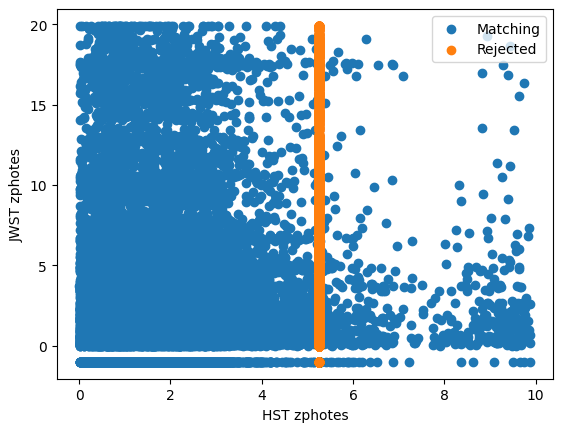

In [87]:
plt.scatter(UDSMatching_Table['HSTZPHOTE'], UDSMatching_Table['JWSTZPHOTE'], label='Matching')
plt.scatter(UDSRejected_Table['HSTZPHOTE'], UDSRejected_Table['JWSTZPHOTE'], label='Rejected')
plt.xlabel('HST zphotes')
plt.ylabel('JWST zphotes')
plt.legend()
plt.show()
